### See if you can use neural nets to perform regression like cibersort
Simulate a bunch of RNA data and train a model on it to see if it performs well on deconvolution tasks.
Right now all I can do is generate new samples from existing data and train it on them.

So first what I have to do is reduce the datas dimensionality sufficently so that a large portion of the variance is explained. Then I will fit it to a GMM and generate points. As of right now i have to use the predictions made from cibersort which isnt exactly what I wanted to do but we dont have ground truth data so it wouild be hard to do it any other way.

### Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import TumorDecon as td
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import mean_absolute_error

### To be made into class for nn_decomposition

In [3]:
def nate_sort(rna_sample, sig_df, nu=0.5, C=1.0, kernel='linear', shrinking=True):
    import numpy as np
    from sklearn.model_selection import GridSearchCV

    # If a numerical of nu not explicitly specified, use gridsearch to find the best nu:
    if nu == 'best':
        
        gridsearch = GridSearchCV(MLPRegressor(solver="lbfgs"), cv=5, param_grid={"learning_rate_init":[.001,.005,.01,.02,.1]}, scoring='neg_mean_squared_error', refit=True, iid=False)
        gridsearch.fit(sig_df, rna_sample)
        lr = gridsearch.best_params_['learning_rate_init']
        

    # Fit nuSVR with best (or specified) value of nu:
    clf = MLPRegressor(solver="lbfgs", learning_rate_init=lr)
    clf.fit(sig_df, rna_sample)

    # Replace negative "frequencies" with 0:
    weights = np.array(clf.coef_)[0] # equivalent to np.matmul(np.array(clf.dual_coef_), np.array(clf.support_vectors_))[0]
    weights[weights<0] = 0
    # Sum to 1 contraint:
    weights = weights / np.sum(weights)

    return weights
def nate_sort_main(rna_df, sig_df, patient_IDs='ALL', args={}):
    for patient in patient_list:
        if patient in rna_df.columns:
            cell_freqs_df[patient] = cibersort(rna_df[patient], sig_df, nu=nu, C=C, kernel=kernel, shrinking=shrinking)
        else:
            raise ValueError("patient_ID ({!r}) not present in rna dataframe".format(patient))
            return
    cell_freqs_df = cell_freqs_df.transpose()
    return cell_freqs_df

### Read Data

In [4]:
df = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/scripts/TumorDecon/data/Simulation_data/Simulation_mixture.csv",index_col="Patient")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
Patient,,,,,,,,,,,,,,,,,,,,,
0,0.041987,0.029400,0.058375,0.065183,0.011434,0.054252,0.051492,0.050393,0.019502,0.050503,...,0.055866,0.048454,0.014117,0.028026,0.063896,0.054038,0.057907,0.041855,0.064365,0.034044
1,0.029913,0.048027,0.008742,0.062388,0.021600,0.041344,0.019164,0.062305,0.065441,0.043912,...,0.078530,0.023266,0.084164,0.035252,0.071408,0.001722,0.065863,0.019781,0.084790,0.037326
2,0.060445,0.002421,0.016912,0.079836,0.073710,0.002900,0.041895,0.037881,0.080806,0.042998,...,0.015474,0.066772,0.047766,0.087620,0.043304,0.087087,0.009160,0.013183,0.049630,0.066232
3,0.062324,0.057795,0.021215,0.018881,0.108848,0.030902,0.038093,0.073227,0.104172,0.040704,...,0.016990,0.021771,0.021409,0.055658,0.071423,0.047555,0.048253,0.046857,0.039450,0.000802
4,0.023462,0.067551,0.033406,0.079458,0.038118,0.005731,0.055723,0.046567,0.057377,0.077398,...,0.011191,0.054797,0.052404,0.009651,0.081185,0.035069,0.074087,0.056898,0.040362,0.001412


In [5]:
df2 = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/scripts/TumorDecon/data/Simulation_data/Simulation_SNR100to5.csv",index_col="Hugo_Symbol")
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,189.364311,276.227372,104.267251,28.697054,296.146820,208.322157,343.290502,362.571761,69.765975,108.687679,...,263.371765,0.000000,81.340653,249.694179,329.039262,298.426071,246.263884,183.588010,168.999810,245.678629
A2M,1364.256599,1239.289091,2116.908009,1768.456793,1136.012086,729.338018,1070.376415,841.686383,1606.747140,1354.015708,...,1733.195269,1894.002367,1911.714906,1486.086606,1061.448100,1331.084175,2495.915515,1443.909308,2008.877540,128.430483
A4GALT,0.000000,233.820915,116.652581,312.173105,0.000000,190.201734,51.227503,0.000000,0.000000,230.514764,...,0.000000,0.000000,12.509306,214.052744,35.980749,0.000000,170.408628,0.000000,143.959652,44.448153
A4GNT,284.196389,277.334832,345.413967,458.714968,214.712847,212.083277,182.001453,166.074495,408.083165,286.878666,...,442.743888,0.000000,30.756553,0.000000,495.355076,63.384024,139.374166,413.569199,71.118304,103.270241
AAAS,131.015559,29.684689,131.304606,0.945879,224.295002,140.637259,63.511066,445.517859,37.338367,82.247556,...,99.726423,448.633177,283.418826,47.189144,47.417713,0.000000,205.780367,0.000000,0.000000,166.116612


Goal is to make a thing which looks at the hugo symnbol finds the index and puts the respective number there.

In [6]:
lm22 = td.read_lm22_file()

In [7]:
lm22.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
ABCB4,555.713449,10.744235,7.225819,4.311280,4.605860,7.406442,8.043976,6.469993,7.833082,9.312295,...,6.202496,7.951360,27.557710,121.432277,114.636747,4.872184,4.727985,34.113659,15.030530,14.906888
ABCB9,15.603544,22.094787,653.392328,24.223723,35.671507,30.048192,38.455423,17.604795,46.073657,19.715722,...,20.309426,56.251887,29.380878,40.390260,123.993305,23.384603,53.466757,23.615746,29.786442,33.679147
ACAP1,215.305951,321.621021,38.616872,1055.613378,1790.097170,922.152747,340.883424,1107.798265,1995.482601,280.075719,...,190.879024,48.972217,30.974254,23.055150,61.386550,26.412923,104.200198,73.607932,696.442802,596.025961
ACHE,15.117949,16.648847,22.123737,13.428288,27.187732,18.444927,13.441268,14.805542,24.652712,33.658448,...,16.375268,13.692963,1373.069620,48.585761,16.715474,193.159977,13.948778,20.501249,40.414927,22.766494
ACP5,605.897384,1935.201479,1120.104684,306.312519,744.656599,557.819820,248.546932,711.949744,958.916018,493.969120,...,512.931382,13644.172300,1062.475909,7633.960182,13825.053630,3989.865169,263.497930,323.381277,860.563374,307.142798


### Normalize Data

In [8]:
def encode_inputs(rna_df,sig_df):
    df_temp = td.df_normalization(rna_df,"minmax")
    rna_df_red ,sig_df_red = td.keep_common_genes(df_temp,sig_df)
    df_temp = rna_df_red.T
    return df_temp

In [9]:
v = encode_inputs(df2,lm22)

In [10]:
v.head()

Hugo_Symbol,ABCB4,ABCB9,ACAP1,ACHE,ACP5,ADAM28,ADAMDEC1,ADAMTS3,ADRB2,AIF1,...,ZBTB10,ZBTB32,ZFP36L2,ZNF135,ZNF165,ZNF204P,ZNF222,ZNF286A,ZNF324,ZNF442
0,0.000000,0.008741,0.018700,0.000000,0.065185,0.000000,0.024267,0.000192,0.026440,0.042060,...,0.000682,0.000000,0.028918,0.003554,0.013822,0.002950,0.000000,0.006116,0.001773,0.000000
1,0.004521,0.003642,0.001143,0.003527,0.062989,0.002774,0.028970,0.004364,0.033619,0.054960,...,0.011550,0.006813,0.026780,0.000017,0.018506,0.001911,0.000000,0.009289,0.000000,0.001291
2,0.001469,0.002809,0.017536,0.006876,0.085042,0.012947,0.042777,0.000000,0.016409,0.061512,...,0.014261,0.002745,0.027155,0.000000,0.007718,0.006188,0.000000,0.007140,0.000000,0.000000
3,0.000000,0.002050,0.014800,0.000000,0.066475,0.010734,0.018472,0.003992,0.025128,0.041730,...,0.005809,0.000000,0.025412,0.002140,0.007833,0.000000,0.010934,0.004291,0.000000,0.004756
4,0.003631,0.010059,0.011671,0.006006,0.067268,0.005653,0.031315,0.003654,0.032530,0.030658,...,0.004715,0.006292,0.024645,0.000000,0.006716,0.002526,0.000000,0.006413,0.002199,0.000000


### Generate new data from ground truth data

In [11]:
from sklearn.ensemble import IsolationForest
def generate_data(num_samples, x_df, y_df,n_components=6):
    temp_arr = np.empty([x_df.shape[0]-20,x_df.shape[1]+y_df.shape[1]])
    x_df = x_df.values
    y_df = y_df.values
    for i in range(len(temp_arr)):
        for j in range(len(temp_arr[1])):
            if j < x_df.shape[1]:
                temp_arr[i][j] = x_df[i][j]
            else:
                temp_arr[i][j] = y_df[i][j-x_df.shape[1]]

    bgm = BayesianGaussianMixture(n_components=n_components)
    bgm.fit(temp_arr)
    clf = IsolationForest().fit(temp_arr)
    samples = []
    while len(samples) < num_samples:
        sample = bgm.sample(num_samples-len(samples))[0]
        outliers = clf.predict(sample)
        for i in range(len(outliers)):
            if outliers[i] == 1 or True:
                samples.append(sample[i])
            
    samples = np.asarray(samples)
    sampled_x = samples[:,:x_df.shape[1]]
    sampled_y = samples[:,x_df.shape[1]:]
    return sampled_x, sampled_y

In [12]:
generated_x, generated_y = generate_data(100000, v, df,n_components=80)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


### NN Model

In [13]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(547)),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(22)
    ]
)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae','mape'])

In [14]:

#X_train, X_test, y_train, y_test = train_test_split(v.values, df.values, test_size=0.2, random_state=42)

In [15]:
history = model.fit(generated_x, generated_y, epochs=20, 
                    validation_data=(v.values[-20:], df.values[-20:]))

Train on 100000 samples, validate on 20 samples
Epoch 1/20
100000/100000 [==============================] - 12s 118us/sample - loss: 0.0056 - mae: 0.0056 - mape: 13.7318 - val_loss: 0.0169 - val_mae: 0.0169 - val_mape: 157.3045
Epoch 2/20
100000/100000 [==============================] - 11s 105us/sample - loss: 0.0039 - mae: 0.0039 - mape: 9.5959 - val_loss: 0.0167 - val_mae: 0.0167 - val_mape: 159.8481
Epoch 3/20
100000/100000 [==============================] - 10s 103us/sample - loss: 0.0037 - mae: 0.0037 - mape: 9.0819 - val_loss: 0.0166 - val_mae: 0.0166 - val_mape: 162.4385
Epoch 4/20
100000/100000 [==============================] - 10s 100us/sample - loss: 0.0036 - mae: 0.0036 - mape: 8.8341 - val_loss: 0.0170 - val_mae: 0.0170 - val_mape: 168.7075
Epoch 5/20
100000/100000 [==============================] - 10s 100us/sample - loss: 0.0035 - mae: 0.0035 - mape: 8.6348 - val_loss: 0.0167 - val_mae: 0.0167 - val_mape: 165.6890
Epoch 6/20
100000/100000 [==============================

Text(0, 0.5, 'Accuracy')

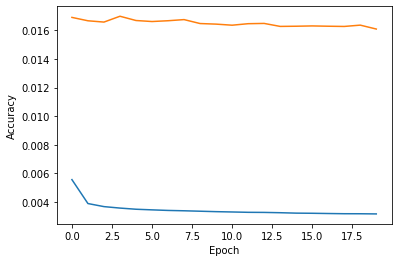

In [16]:
plt.plot(history.history['mae'], label='root_mean_squared_error')    #blue
plt.plot(history.history['val_mae'], label = 'val_root_mean_squared_error')     #orange
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [17]:
min(history.history['val_mae'])

0.016101088

In [18]:
predictions = model.predict(v.values[-20:])

### Run cibersort for comparison

In [19]:
c_results = td.cibersort_main(lm22,v.T)
c_results=c_results.T

Running CiberSort...


In [20]:
print("NN MAE:",mean_absolute_error(df.values[-20:],predictions))
print("CIBERSORT MAE:",mean_absolute_error(df.values[-20:],c_results.values[-20:]))

NN MAE: 0.016101088965085174
CIBERSORT MAE: 0.036199511590429785


In [21]:
nn_results = pd.DataFrame(data=predictions,columns=c_results.columns)
nn_results.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.064715,0.039995,0.058143,0.050737,0.034200,0.027771,0.060639,0.042861,0.042031,0.045252,...,0.045876,0.041618,0.038952,0.062070,0.058917,0.050739,0.030926,0.029829,0.034572,0.053659
1,0.043170,0.042832,0.029593,0.052991,0.045203,0.061785,0.048511,0.058583,0.062648,0.037296,...,0.049853,0.049966,0.021238,0.047106,0.053558,0.033372,0.029241,0.055956,0.037973,0.056171
2,0.051758,0.054423,0.026251,0.031897,0.053602,0.031140,0.015109,0.041395,0.033155,0.059235,...,0.051349,0.036803,0.035689,0.052822,0.056495,0.065179,0.046646,0.037041,0.038647,0.050504
3,0.052549,0.030577,0.030906,0.061183,0.043578,0.030919,0.026644,0.044915,0.047633,0.048845,...,0.045146,0.032408,0.050533,0.044194,0.035431,0.059402,0.044639,0.028655,0.058192,0.069470
4,0.025786,0.046066,0.034253,0.036819,0.042948,0.044236,0.042208,0.031900,0.044101,0.045252,...,0.033082,0.055030,0.049334,0.062506,0.058334,0.051591,0.057377,0.055036,0.043416,0.047315


### Make plots for comparison

C:\Users\NathanGrant\Programs\TripodsREU\scripts\TumorDecon\visualization.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df<0]=0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


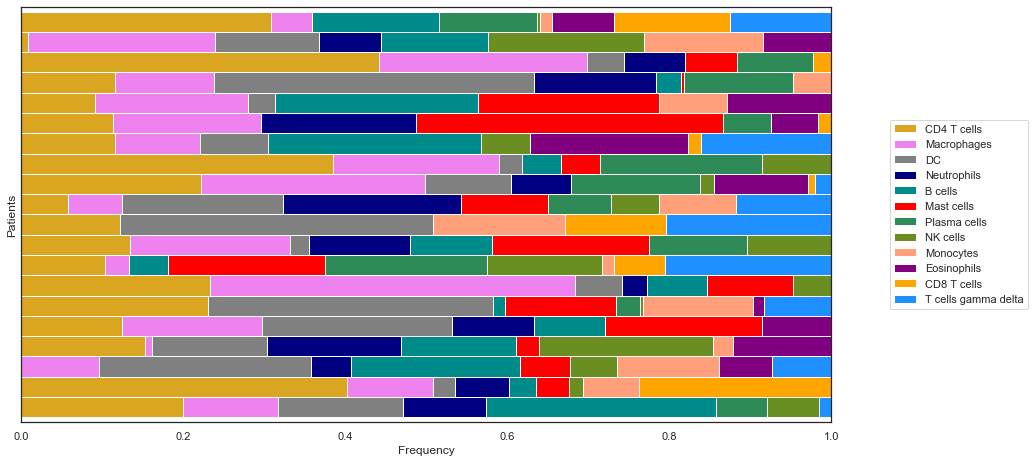

In [22]:
td.cell_frequency_barchart(c_results[-20:])

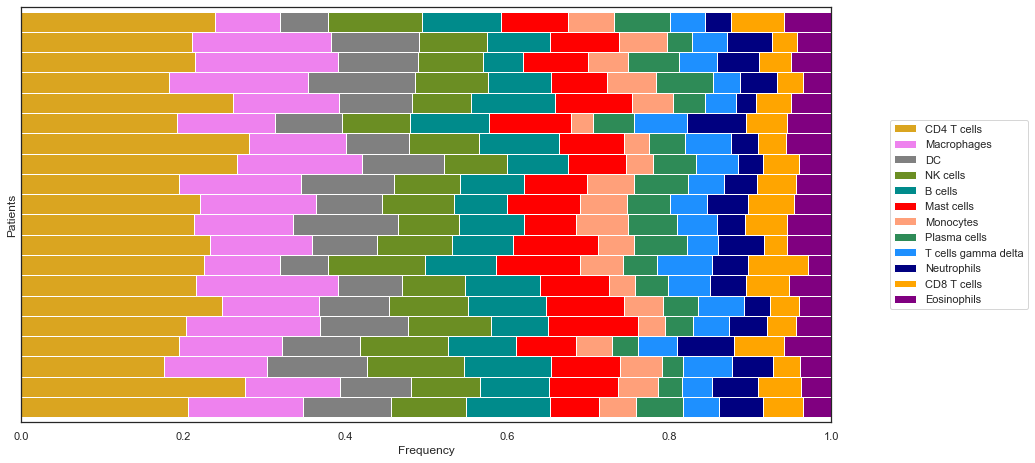

In [23]:
td.cell_frequency_barchart(nn_results)

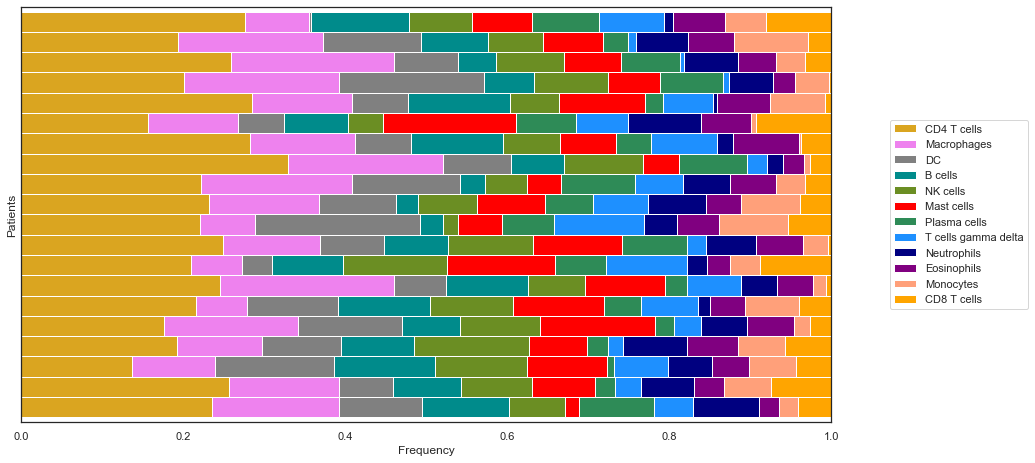

In [24]:
df.columns =c_results.columns
df.head()
td.cell_frequency_barchart(df.iloc[-20:])

### Find correlation between methods and ground truth

In [25]:
from scipy.stats import pearsonr
def compute_mean_cell_p_correlation(ground_truth,predicted):
    x=[]
    y=[]
    avg_sample = []
    for i in range(len(ground_truth)):
        avg_sample.append(pearsonr(ground_truth[i],predicted[i]))
    avg_cell_correlation = []
    for i in range(len(ground_truth[0])):
        avg_cell_correlation.append(pearsonr(ground_truth[:,i],predicted[:,i]))
    return np.mean(avg_sample),np.mean(avg_cell_correlation)

In [26]:
df_comb = td.combine_celltypes(df)
nn_results_comb = td.combine_celltypes(nn_results)
c_results_comb = td.combine_celltypes(c_results)

In [27]:
compute_mean_cell_p_correlation(df_comb.iloc[-20:].values,nn_results_comb.values)

(0.46634918435703654, 0.40127832993048546)

In [28]:
compute_mean_cell_p_correlation(df_comb.iloc[-20:].values,c_results_comb.iloc[-20:].values)

(0.3729943992546055, 0.3792319455435584)

### Make plots for data

0.933229642198538

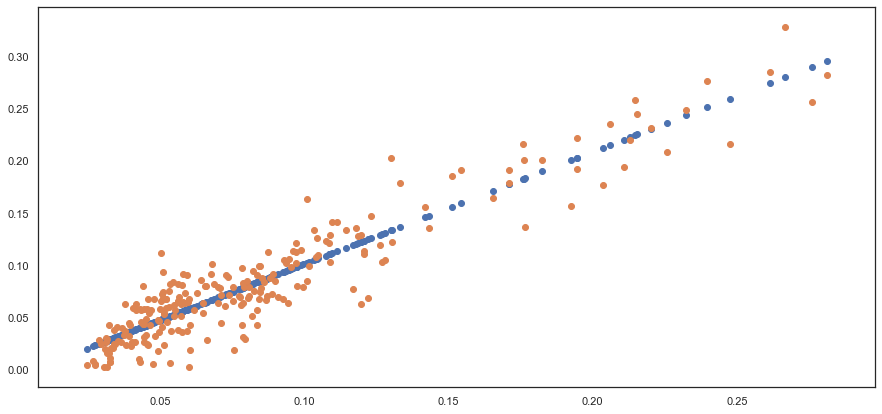

In [29]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(nn_results_comb.values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))
plt.scatter(nn_results_comb.values.flatten().reshape(-1, 1),lin.predict(nn_results_comb.values.flatten().reshape(-1, 1)))
plt.scatter(nn_results_comb.values,df_comb.iloc[-20:].values)
lin.score(nn_results_comb.values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))**.5

0.7086814215247145

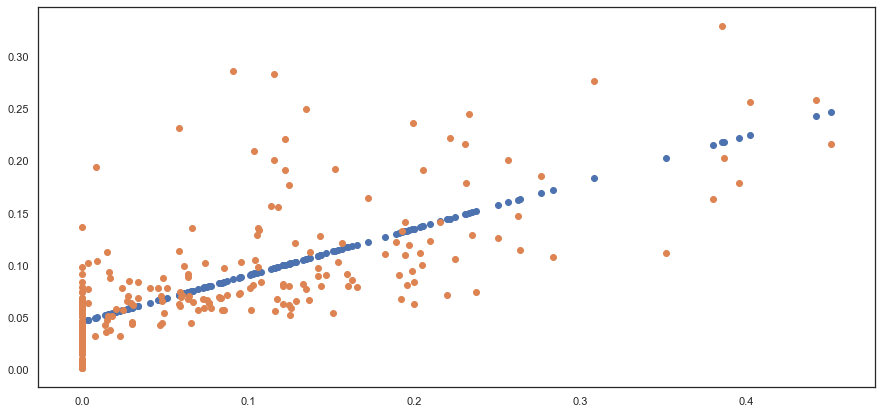

In [30]:
lin = LinearRegression().fit(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))
plt.scatter(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1),lin.predict(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1)))
plt.scatter(c_results_comb.iloc[-20:].values,df_comb.iloc[-20:].values)
lin.score(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))**.5

## Test on CIBERSORT ground truth data

In [31]:
cibersort_gep = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/ExampleMixtures-GEPs.txt",delimiter="\t",index_col="Hugo_Symbol")
cibersort_gep.head()

,Mix1,Mix2,Mix3,Mix4,Mix5
Hugo_Symbol,,,,,
A1CF,317.722091,293.341077,217.299844,324.780988,249.629992
A2M,151.455508,530.830854,837.158282,692.726721,2510.675378
A4GALT,73.512724,92.717987,64.725953,71.602486,81.679389
A4GNT,288.295490,259.639816,158.096971,282.407327,197.121171
AAAS,108.864797,106.834378,103.505401,50.651212,65.309679


In [32]:
cibersort_ground_truth = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/ExampleMixtures-GroundTruth.txt",delimiter="\t",header=None)
cibersort_ground_truth.columns = nn_results.columns
cibersort_ground_truth.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.18,0.16,0.13,0.11,0.09,0.07,0.06,0.05,0.04,0.03,...,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,0.20,0.00,0.19,0.00,0.18,0.00,0.10,0.00,0.09,0.00,...,0.05,0.00,0.04,0.00,0.04,0.00,0.02,0.00,0.02,0.00
2,0.00,0.00,0.01,0.01,0.01,0.02,0.03,0.05,0.07,0.11,...,0.11,0.07,0.05,0.03,0.02,0.01,0.01,0.01,0.00,0.00
3,0.17,0.12,0.08,0.06,0.03,0.02,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.02,0.03,0.06,0.08,0.12,0.17
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.04,...,0.02,0.04,0.09,0.11,0.08,0.05,0.04,0.07,0.14,0.20


In [33]:
c_normalized = encode_inputs(cibersort_gep,lm22)
c_normalized.shape

(5, 547)

In [34]:
predictions_2 = pd.DataFrame(data=model.predict(c_normalized.values),columns=c_results.columns)
cibersort_pred = td.cibersort_main(lm22,c_normalized.T)

Running CiberSort...


## Compare Plots

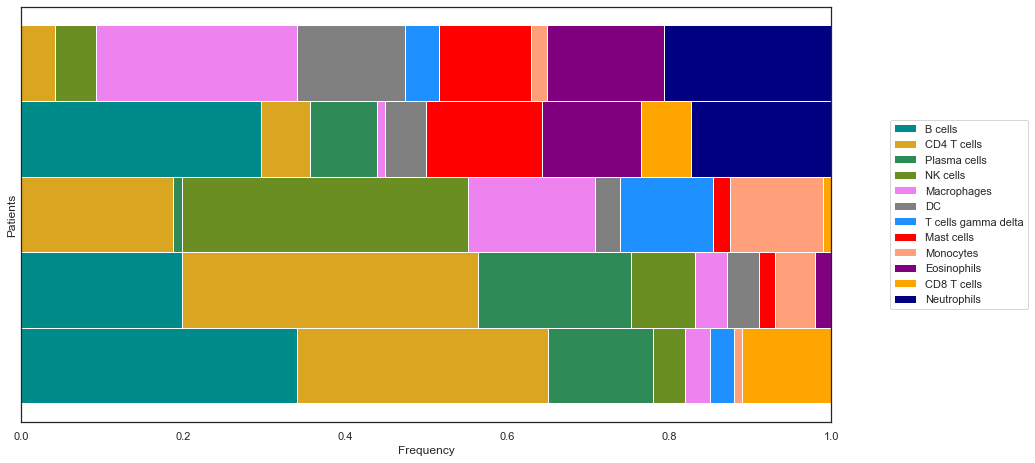

In [35]:
td.cell_frequency_barchart(cibersort_ground_truth)

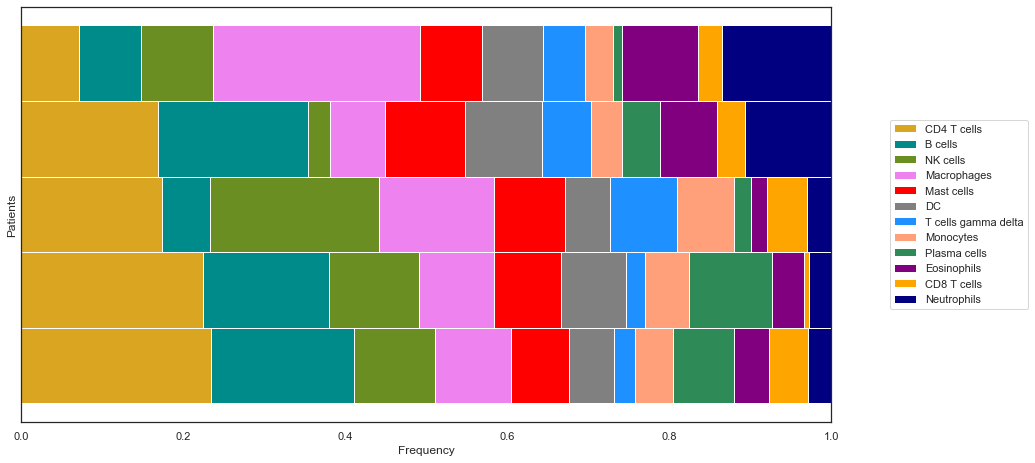

In [36]:
td.cell_frequency_barchart(predictions_2)

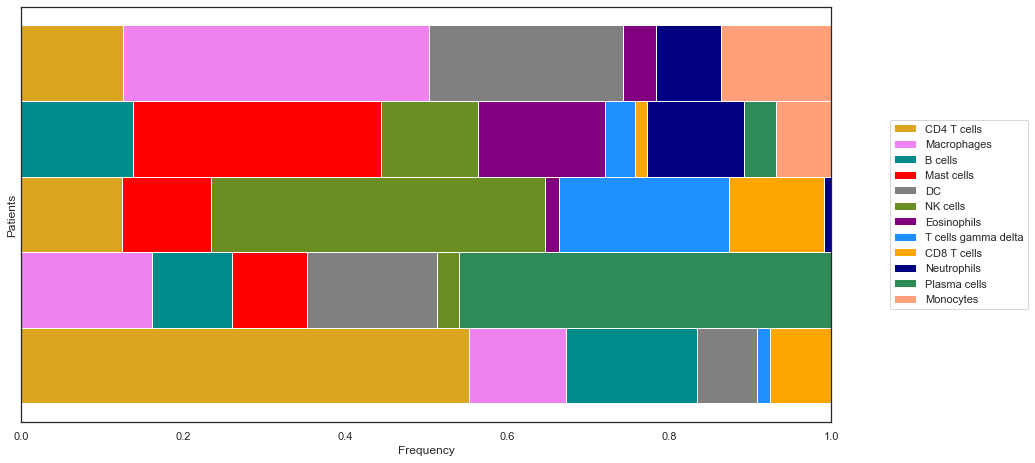

In [37]:
td.cell_frequency_barchart(cibersort_pred.T)

In [38]:
compute_mean_cell_p_correlation(cibersort_ground_truth.values,predictions_2.values)

(0.4016300652004893, 0.46809740589159893)

In [39]:
compute_mean_cell_p_correlation(cibersort_ground_truth.values,cibersort_pred.T.values)

(0.28166496861922957, 0.43127513907838094)

## Make Correlation Plots

0.7753846130874442

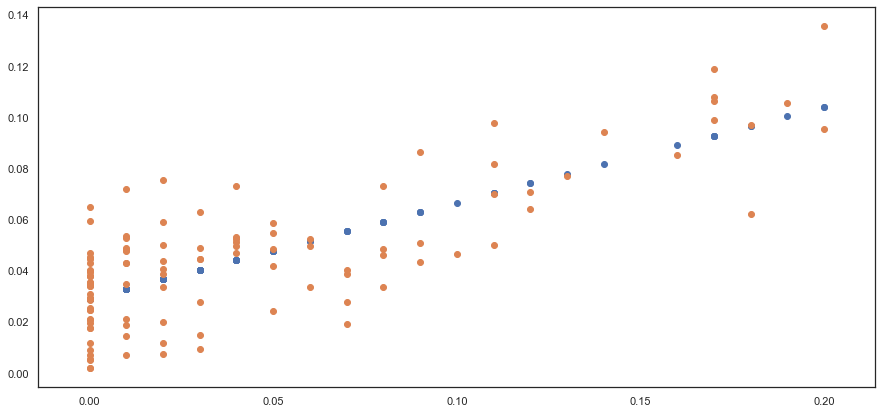

In [40]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(cibersort_ground_truth.values.flatten().reshape(-1, 1),predictions_2.values.flatten().reshape(-1, 1))
plt.scatter(cibersort_ground_truth.values.flatten().reshape(-1, 1),lin.predict(cibersort_ground_truth.values.flatten().reshape(-1, 1)))
plt.scatter(cibersort_ground_truth.values,predictions_2.values)
lin.score(cibersort_ground_truth.values.flatten().reshape(-1, 1),predictions_2.values.flatten().reshape(-1, 1))**.5

0.5031232728971158

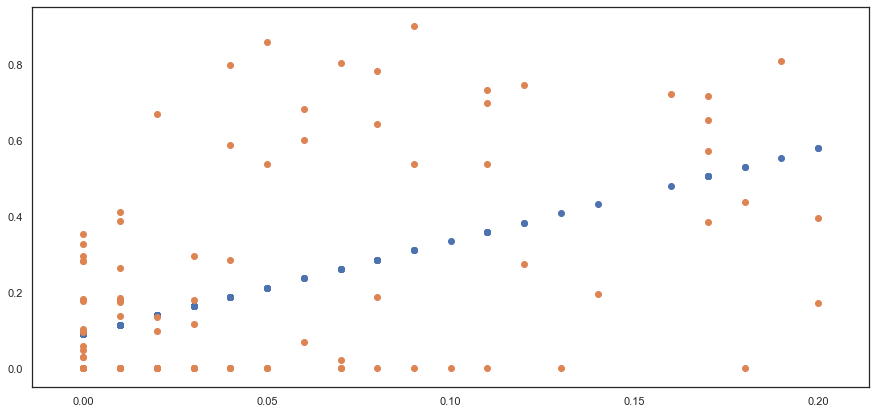

In [41]:
lin = LinearRegression().fit(cibersort_ground_truth.values.flatten().reshape(-1, 1),cibersort_pred.T.values.flatten().reshape(-1, 1))
plt.scatter(cibersort_ground_truth.values.flatten().reshape(-1, 1),lin.predict(cibersort_ground_truth.values.flatten().reshape(-1, 1)))
plt.scatter(cibersort_ground_truth.values,cibersort_pred.T.values)
lin.score(cibersort_ground_truth.values.flatten().reshape(-1, 1),cibersort_pred.T.values.flatten().reshape(-1, 1))**.5

In [42]:
print("NN MAE:",mean_absolute_error(cibersort_ground_truth.values,predictions_2.values))
print("CIBERSORT MAE:",mean_absolute_error(cibersort_ground_truth.values,cibersort_pred.T.values))

NN MAE: 0.031669994236393405
CIBERSORT MAE: 0.1824686514949728


## Test on CIBERSORT Ground truth data for PBMC 

In [106]:
pbmc_groundtruth = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/pbmc_groundtruth.txt",delimiter="\t",index_col="Patient_ID")
pbmc_groundtruth.columns

Index(['B cells naive', 'B cells memory', 'T cells CD8', 'T cells CD4 naive',
       'T cells CD4 memory resting', 'T cells CD4 memory activated',
       'T cells gamma delta', 'NK cells resting', 'Monocytes'],
      dtype='object')

In [104]:
c_results.columns

Index(['B cells naive', 'B cells memory', 'Plasma cells', 'T cells CD8',
       'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils'],
      dtype='object')

In [64]:
pbmc_expression = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/pbmc_expression.txt",delimiter="\t",index_col="Hugo_Symbol")
pbmc_expression.head()

,17-002,17-006,17-019,17-023,17-026,17-027,17-030,17-034,17-040,17-041,17-042,17-043,17-045,17-047,17-054,17-055,17-057,17-058,17-060,17-061
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,
7A5,22.315899,25.281322,27.095850,22.008669,28.051383,19.973289,23.588307,22.315899,24.590003,23.752377,24.420147,22.627417,22.784803,25.812536,24.420147,23.752377,21.856644,21.555737,27.095850,22.315899
A1BG,22.161751,36.252284,23.263560,27.665191,25.812536,25.281322,24.761040,25.634236,22.471118,25.992077,31.124958,21.112127,23.917588,27.095850,24.420147,23.263560,36.758347,37.014022,27.857618,36.001872
A1CF,24.251465,21.258973,22.315899,25.457167,23.752377,29.242606,22.471118,23.917588,23.588307,24.590003,22.315899,24.761040,22.943284,22.008669,24.083948,23.752377,23.752377,31.341450,21.555737,25.106691
A26C3,22.784803,23.917588,21.856644,30.484416,24.590003,25.992077,19.973289,27.857618,23.752377,23.917588,28.246496,26.172866,30.696452,24.251465,20.966294,26.354913,28.840015,31.341450,23.263560,27.095850
A2BP1,42.517946,22.627417,21.258973,20.966294,22.784803,26.354913,21.555737,25.106691,22.008669,20.966294,23.263560,24.420147,27.857618,25.106691,20.392970,21.258973,20.677645,21.856644,20.534814,22.161751


In [65]:
pbmc_e = encode_inputs(pbmc_expression,lm22)
pbmc_e.head()

Hugo_Symbol,ABCB4,ABCB9,ACAP1,ACHE,ACP5,ADAM28,ADAMDEC1,ADAMTS3,ADRB2,AIF1,...,ZBP1,ZBTB10,ZBTB32,ZFP36L2,ZNF135,ZNF165,ZNF222,ZNF286A,ZNF324,ZNF442
17-002,0.000508,0.000360,0.009334,0.000373,0.000413,0.000309,0.000386,0.000042,0.006710,0.090777,...,0.004468,0.000322,0.000522,0.053367,0.000309,0.007239,0.000823,0.000386,0.000872,0.000322
17-006,0.000990,0.000872,0.011120,0.000480,0.003313,0.000682,0.000284,0.000322,0.005403,0.039793,...,0.004808,0.000608,0.000494,0.031808,0.000248,0.006002,0.001263,0.000142,0.001833,0.000623
17-019,0.001096,0.000939,0.016102,0.000623,0.001566,0.001879,0.000272,0.000360,0.006107,0.079390,...,0.005548,0.000212,0.001025,0.052612,0.000165,0.000872,0.000956,0.000728,0.001188,0.000623
17-023,0.000713,0.000922,0.009111,0.000550,0.000579,0.000297,0.000522,0.000386,0.010605,0.075027,...,0.003347,0.000297,0.000426,0.056496,0.000373,0.003553,0.000579,0.000165,0.000564,0.001903
17-026,0.000236,0.000335,0.010690,0.000236,0.000791,0.001263,0.000212,0.000224,0.006430,0.060658,...,0.006653,0.000467,0.000399,0.066520,0.000309,0.005261,0.000508,0.000212,0.000973,0.000413


In [66]:
for col in list(c_normalized.columns):
    if col not in list(pbmc_e):
        pbmc_e[col] = 0

In [67]:
pbmc_e.head()

Hugo_Symbol,ABCB4,ABCB9,ACAP1,ACHE,ACP5,ADAM28,ADAMDEC1,ADAMTS3,ADRB2,AIF1,...,TRAC,TRAV12-2,TRAV13-1,TRAV13-2,TRAV21,TRAV8-6,TRAV9-2,TRBC1,TRDC,ZNF204P
17-002,0.000508,0.000360,0.009334,0.000373,0.000413,0.000309,0.000386,0.000042,0.006710,0.090777,...,0,0,0,0,0,0,0,0,0,0
17-006,0.000990,0.000872,0.011120,0.000480,0.003313,0.000682,0.000284,0.000322,0.005403,0.039793,...,0,0,0,0,0,0,0,0,0,0
17-019,0.001096,0.000939,0.016102,0.000623,0.001566,0.001879,0.000272,0.000360,0.006107,0.079390,...,0,0,0,0,0,0,0,0,0,0
17-023,0.000713,0.000922,0.009111,0.000550,0.000579,0.000297,0.000522,0.000386,0.010605,0.075027,...,0,0,0,0,0,0,0,0,0,0
17-026,0.000236,0.000335,0.010690,0.000236,0.000791,0.001263,0.000212,0.000224,0.006430,0.060658,...,0,0,0,0,0,0,0,0,0,0


In [68]:
pbmc_e.sort_index(axis=1)

Hugo_Symbol,ABCB4,ABCB9,ACAP1,ACHE,ACP5,ADAM28,ADAMDEC1,ADAMTS3,ADRB2,AIF1,...,ZBTB10,ZBTB32,ZFP36L2,ZNF135,ZNF165,ZNF204P,ZNF222,ZNF286A,ZNF324,ZNF442
17-002,0.000508,0.000360,0.009334,0.000373,0.000413,0.000309,0.000386,0.000042,0.006710,0.090777,...,0.000322,0.000522,0.053367,0.000309,0.007239,0,0.000823,0.000386,0.000872,0.000322
17-006,0.000990,0.000872,0.011120,0.000480,0.003313,0.000682,0.000284,0.000322,0.005403,0.039793,...,0.000608,0.000494,0.031808,0.000248,0.006002,0,0.001263,0.000142,0.001833,0.000623
17-019,0.001096,0.000939,0.016102,0.000623,0.001566,0.001879,0.000272,0.000360,0.006107,0.079390,...,0.000212,0.001025,0.052612,0.000165,0.000872,0,0.000956,0.000728,0.001188,0.000623
17-023,0.000713,0.000922,0.009111,0.000550,0.000579,0.000297,0.000522,0.000386,0.010605,0.075027,...,0.000297,0.000426,0.056496,0.000373,0.003553,0,0.000579,0.000165,0.000564,0.001903
17-026,0.000236,0.000335,0.010690,0.000236,0.000791,0.001263,0.000212,0.000224,0.006430,0.060658,...,0.000467,0.000399,0.066520,0.000309,0.005261,0,0.000508,0.000212,0.000973,0.000413
17-027,0.001007,0.000682,0.014585,0.000309,0.001833,0.000905,0.000608,0.000272,0.005168,0.047607,...,0.000399,0.000728,0.053749,0.000108,0.002276,0,0.000426,0.000075,0.002047,0.000775
17-030,0.000467,0.001609,0.011747,0.000236,0.001903,0.000453,0.000248,0.000212,0.006941,0.075027,...,0.000399,0.000536,0.058541,0.000176,0.002172,0,0.000608,0.000176,0.001114,0.000713
17-034,0.000413,0.001132,0.008063,0.000212,0.000682,0.001503,0.000188,0.000713,0.007931,0.072934,...,0.001114,0.000188,0.034950,0.000130,0.013508,0,0.000652,0.000373,0.002023,0.000439
17-040,0.000682,0.001096,0.007866,0.000176,0.002575,0.001809,0.000536,0.000297,0.012600,0.076635,...,0.000839,0.000839,0.024273,0.000130,0.007610,0,0.001719,0.000086,0.002329,0.000807
17-041,0.000297,0.000956,0.011474,0.000373,0.000522,0.001060,0.000922,0.000212,0.007610,0.075027,...,0.000922,0.000248,0.040661,0.000236,0.012698,0,0.000623,0.000153,0.001566,0.001341


In [69]:
pbmc_predictions = model.predict(pbmc_e.values)

In [70]:
pbmcnn_results = pd.DataFrame(data=pbmc_predictions,columns=c_results.columns)

In [71]:
cibersort_pred = td.cibersort_main(lm22,pbmc_e.T)

Running CiberSort...


In [113]:
pbmc_groundtruth['T cells regulatory (Tregs)'] = 0
pbmc_groundtruth['T cells follicular helper'] = 0
pbmc_groundtruth['NK cells resting'] = 0
pbmc_groundtruth['Macrophages M0'] = 0
pbmc_groundtruth['Macrophages M1'] = 0
pbmc_groundtruth['Macrophages M2'] = 0
pbmc_groundtruth['Mast cells activated'] = 0
pbmc_groundtruth['Mast cells resting'] = 0
pbmc_groundtruth['Dendritic cells resting'] = 0
pbmc_groundtruth['Dendritic cells activated'] = 0
pbmc_groundtruth['Plasma cells'] = 0
pbmc_groundtruth['NK cells activated'] = 0
pbmc_groundtruth['Eosinophils'] = 0
pbmc_groundtruth['Neutrophils'] = 0
pbmc_groundtruth.columns = nn_results.columns

In [114]:
pbmc_groundtruth.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Patient_ID,,,,,,,,,,,,,,,,,,,,,
17-002,12.36,2.96,22.36,10.96,9.43,2.81,5.44,0,17.10,0,...,0,0,0,0,0,0,0,0,0,0
17-006,3.33,1.83,32.05,32.57,11.67,1.68,2.28,0,5.70,0,...,0,0,0,0,0,0,0,0,0,0
17-019,15.09,4.07,17.86,4.53,6.63,1.69,12.49,0,7.99,0,...,0,0,0,0,0,0,0,0,0,0
17-023,16.77,2.95,8.69,7.53,27.54,1.70,0.64,0,17.08,0,...,0,0,0,0,0,0,0,0,0,0
17-026,8.40,4.69,27.98,8.98,21.17,1.92,5.59,0,13.38,0,...,0,0,0,0,0,0,0,0,0,0


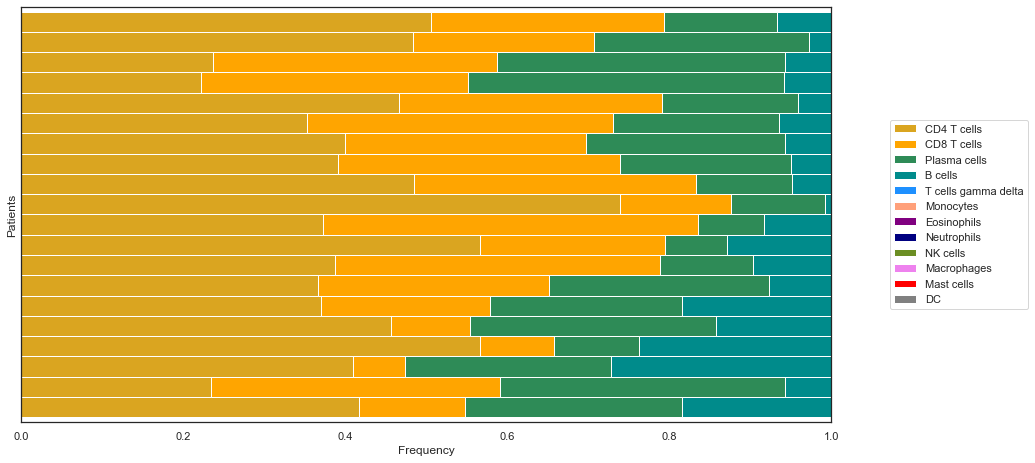

In [116]:
td.cell_frequency_barchart(pbmc_groundtruth)

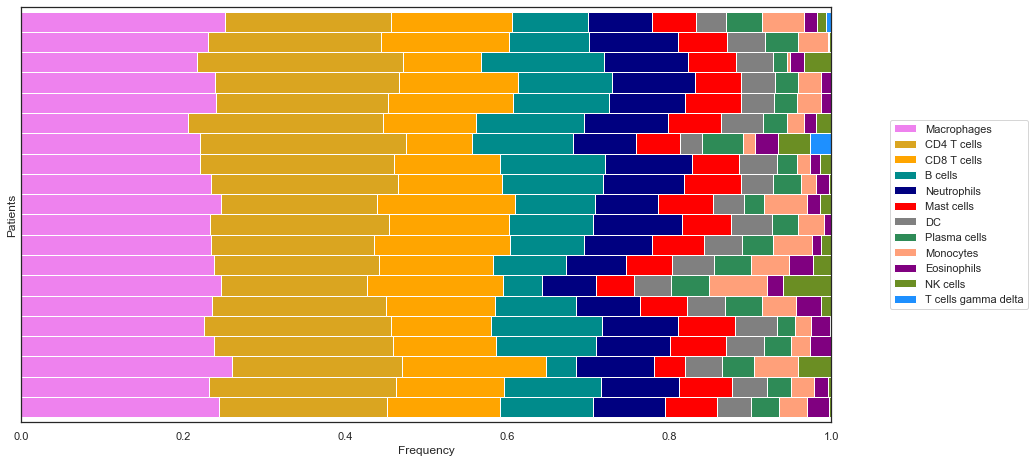

In [117]:
td.cell_frequency_barchart(pbmcnn_results)

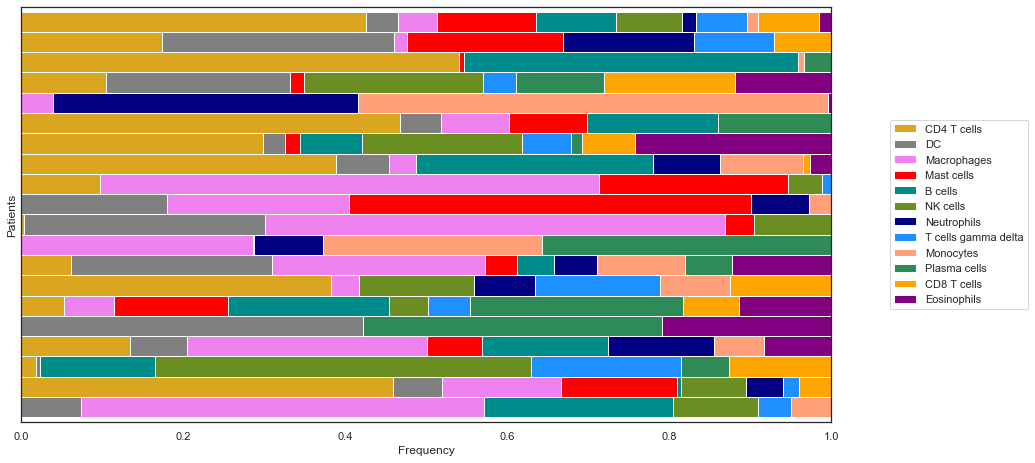

In [120]:
td.cell_frequency_barchart(cibersort_pred.T)

In [123]:
print("NN MAE:",mean_absolute_error(pbmc_groundtruth.values,pbmcnn_results.values))
print("CIBERSORT MAE:",mean_absolute_error(pbmc_groundtruth.values,cibersort_pred.T.values))

NN MAE: 3.963051895021715
CIBERSORT MAE: 3.975360375392074


In [127]:
expression_df = pd.read_excel('C:/Users/NathanGrant/Programs/TripodsREU/data/uvm_tcga_pan_can_atlas_2018/data_RNA_Seq_v2_expression_median_excel.xlsx',index_col="Hugo_Symbol")
expression_df.head()

,TCGA-RZ-AB0B-01,TCGA-V3-A9ZX-01,TCGA-V3-A9ZY-01,TCGA-V4-A9E5-01,TCGA-V4-A9E7-01,TCGA-V4-A9E8-01,TCGA-V4-A9E9-01,TCGA-V4-A9EA-01,TCGA-V4-A9EC-01,TCGA-V4-A9ED-01,...,TCGA-WC-A885-01,TCGA-WC-A888-01,TCGA-WC-A88A-01,TCGA-WC-AA9A-01,TCGA-WC-AA9E-01,TCGA-YZ-A980-01,TCGA-YZ-A982-01,TCGA-YZ-A983-01,TCGA-YZ-A984-01,TCGA-YZ-A985-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
UBE2Q2P2,4.8264,2.1699,0.7299,2.6070,4.7598,1.9773,4.3636,4.5249,0.0000,2.8444,...,4.2702,5.3313,2.4876,9.8639,4.6212,7.7805,0.0000,10.9175,0.9279,3.4030
RPL41P2,91.0674,91.2986,29.1022,20.6022,55.0171,34.4834,32.2545,8.8462,45.6507,46.1481,...,39.3498,76.8241,70.2985,90.9479,86.2960,58.9273,39.6018,59.2057,31.3802,30.2980
RPS6KA2,964.7600,869.0410,640.1460,780.5070,1287.5200,1088.4800,879.2730,558.8230,1054.7400,930.1290,...,763.2960,1105.1000,970.1490,1436.4100,951.7060,801.0690,687.6110,717.3650,806.3090,637.4940
BRCA1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AI894139,174.6680,102.4660,93.4307,33.2805,93.4107,68.2155,21.0909,54.2986,59.0506,53.4753,...,35.2290,117.2890,56.5920,165.6500,192.7340,174.2700,54.8673,183.4980,33.4029,46.5075


In [128]:
abcd = encode_inputs(expression_df,lm22)

In [129]:
new_stuff = model.predict(abcd.values)

ValueError: Error when checking input: expected input_1 to have shape (547,) but got array with shape (510,)